#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Topic modelling with BERTopic`

#### Group 05:
- Karolina Rączkowska 20241250
- Michał Wójcik 20241255
- Hubert Kołomański 20241253
- Marek Rewoliński 20241452
- Christian Deluca 20241264  

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data preparation for topic modelling](#P1)
- [2. Data Modelling (BERTopic) - default model](#P2)
- [3. Data Modelling (BERTopic) - custome model](#P3)
- [3. Model evaluation and visualizations](#P4)


In [ ]:
import time
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import emoji
import Preprocessing_topicM as preproc
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

[1. Data preparation for topic modelling](#P1)

In [ ]:
reviews_raw = pd.read_csv(r"/data_hyderabad/10k_reviews.csv")

In [ ]:
reviews_data = reviews_raw[reviews_raw["Rating"].notna() & reviews_raw["Review"].notna()]
reviews_data.isna().sum()

,0
Restaurant,0
Reviewer,0
Review,0
Rating,0
Metadata,0
Time,0
Pictures,0


In [ ]:
# split UPPERCASE WORDS
def splitting_words_process(word):
    # only upper case letters
    if word.isupper():
        return word

    # more than one upper case letter inside
    elif re.search(r'[A-Z][a-z]*[A-Z]', word):
        split_word = re.findall(r'[A-Z][a-z]*', word)
        return ' '.join(split_word)

    # <2 upper case letters
    else:
        return word

reviews_data['Review'] = reviews_data['Review'].apply(lambda x: ' '.join([splitting_words_process(word) for word in x.split()]))

In [ ]:
# Function to replace 'gud', 'goo', 'gd' with the appropriate 'good'
def replace_gud_with_good(text):
    if isinstance(text, str):
        # Define the regex pattern to match 'gud', 'goo', 'gd' in various capitalizations
        pattern = re.compile(r'\b([Gg][Uu][Dd]|[Gg][Oo][Oo]|[Gg][Dd])\b')

        # Replacement function to check the case of the first letter
        def replacement(match):
            word = match.group()
            # Check if the first letter is uppercase, then return 'Good', else 'good'
            if word[0].isupper():
                return 'Good'
            else:
                return 'good'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'good'
reviews_data['Review'] = reviews_data['Review'].apply(replace_gud_with_good)

In [ ]:
# Function to replace 'kk', 'Oke', 'k', 'Ok' with 'ok'
def replace_to_ok(text):
    if isinstance(text, str):
        # Define the regex pattern to match the variants of 'ok'
        pattern = re.compile(r'\b(k|kk|Ok|Oke)\b', re.IGNORECASE)

        # Replacement function to return 'ok' for all matched words
        def replacement(match):
            return 'ok'

        # Use re.sub to apply the replacement function
        return pattern.sub(replacement, text)

    return text

# Apply the function to the 'Review' column to replace the variants of 'ok'
reviews_data['Review'] = reviews_data['Review'].apply(replace_to_ok)

In [ ]:
# add space after ! | " | # | $ | % | & | ( | ) | * | + | , | . | : | ; followed immediately by a word
def add_space_after_punctuation(df):

    df['Review'] = df['Review'].apply(lambda text: re.sub(r'([\u0021-\u0026\u0028-\u002C\u002E\u003A-\u003F]+(?=\w))', r'\1 ', text) if isinstance(text, str) else text)
    return df

# Example usage:
reviews_data = add_space_after_punctuation(reviews_data)

In [ ]:
# remove gibberish words like "ggggggggggd", "eshjdgue"
def remove_gibberish(text):
    cleaned_text = re.sub(r'\b\w{15,}\b', '', text)  # removes 15+ words
    cleaned_text = re.sub(r'\b\w*(\w)\1{2,}\w*\b', '', cleaned_text)  # removes words that contain 3+ repeating letters

    return cleaned_text

reviews_data['Review'] = reviews_data['Review'].apply(remove_gibberish)

In [ ]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_data['Review'] = reviews_data['Review'].apply(remove_space_before_punctuation)

In [ ]:
reviews_preproc = reviews_data['Review'].apply(lambda x: preproc.main_pipeline(
    x,
    print_output=False,
    no_stopwords=False,
    custom_stopwords=[],
    convert_diacritics=True,
    no_punctuation=False,
    remove_contractions = True,
    lowercase=False,
    lemmatized=False,
    stemmed=False,
    tokenized_output=False
))

In [ ]:
def remove_space_before_punctuation(text):
    if isinstance(text, str):
        # Define the regex pattern to match spaces before punctuation
        pattern = re.compile(r'\s+([?.!,;:])')

        # Use re.sub to remove spaces before punctuation
        return pattern.sub(r'\1', text)

    return text

# Apply the function to the 'Review' column to remove spaces before punctuation
reviews_preproc = reviews_preproc.apply(remove_space_before_punctuation)

In [ ]:
reviews_preproc = reviews_preproc[reviews_preproc.apply(lambda x: len(x) >= 3 if isinstance(x, str) else False)]

In [ ]:
len(reviews_preproc)

9424

In [ ]:
print(reviews_preproc)

0       The ambience was good, food was quite good. ha...
1       Ambience is too good for a pleasant evening. S...
2       A must try.. great food great ambience. Thnx f...
3       Soumen das and Arun was a great guy. Only beca...
4       Food is good. we ordered Kodi drumsticks and b...
                              ...                        
9995    Madhumathi Mahajan Well to start with nice cou...
9996    This place has never disappointed us.. The foo...
9997    Bad rating is mainly because of "Chicken Bone ...
9998    I personally love and prefer Chinese Food. Had...
9999    Checked in here to try some delicious chinese ...
Name: Review, Length: 9424, dtype: object


[2. Data modelling - default model](#P2)

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(reviews_preproc.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/295 [00:00<?, ?it/s]

In [ ]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 1))
ctfidf_model = ClassTfidfTransformer()
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30,metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
model_base = BERTopic(
    language="english",
    calculate_probabilities=True,
    embedding_model= embedding_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    umap_model= umap_model,
    hdbscan_model=hdbscan_model,
    representation_model={"MMR": MaximalMarginalRelevance(diversity=0.3),
                          "KeyBert": KeyBERTInspired(),
                          "Pos": PartOfSpeech()},
    verbose = True
)
topics_base, probs_base = model_base.fit_transform(reviews_preproc,embeddings)

2024-12-18 14:25:55,324 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 14:26:49,929 - BERTopic - Dimensionality - Completed ✓
2024-12-18 14:26:49,933 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 14:26:54,501 - BERTopic - Cluster - Completed ✓
2024-12-18 14:26:54,516 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 14:27:11,992 - BERTopic - Representation - Completed ✓


In [ ]:
model_base.get_topic_info()

,Topic,Count,Name,Representation,MMR,KeyBert,Pos,Representative_Docs
0,-1,4307,-1_food_good_place_service,"[food, good, place, service, chicken, ambience...","[food, service, chicken, ambience, experience,...","[restaurant, buffet, visit, lunch, food, dishe...","[food, good, place, service, chicken, ambience...",[Amazing food and ambience. Starters were simp...
1,0,3173,0_good_place_food_biryani,"[good, place, food, biryani, chicken, service,...","[place, food, biryani, chicken, visit, restaur...","[biryani, chicken, restaurant, biriyani, buffe...","[good, place, food, biryani, chicken, service,...",[American Wild Wings = Amazing Wings I happene...
2,1,570,1_service_food_zomato_place,"[service, food, zomato, place, manager, asked,...","[service, zomato, manager, order, restaurant, ...","[restaurant, customers, waiters, serving, wait...","[service, food, zomato, place, manager, staff,...",[After hearing a lot about this place I got a ...
3,2,376,2_cake_cream_ice_chocolate,"[cake, cream, ice, chocolate, donuts, shake, b...","[chocolate, donuts, shake, cakes, brownies, cu...","[chocolate, flavors, icecream, flavours, flavo...","[cake, cream, ice, chocolate, donuts, brownie,...",[I have ordered nuts loaded ice cream and also...
4,3,346,3_food_taste_chicken_good,"[food, taste, chicken, good, spicy, bad, tasty...","[food, chicken, spicy, tasty, quality, smell, ...","[food, eat, tasty, meat, chicken, taste, cooki...","[food, taste, chicken, good, spicy, bad, tasty...","[food not good, Chicken taste is not good, ver..."
5,4,242,4_delivery_order_fast_time,"[delivery, order, fast, time, delivered, boy, ...","[delivery, delivered, received, deliver, man, ...","[delivery, deliver, delivered, deliverd, excel...","[delivery, order, fast, time, boy, good, guy, ...","[good delivery, Good delivery, delivery is very]"
6,5,140,5_shawarma_maggi_chicken_rumali,"[shawarma, maggi, chicken, rumali, ordered, sh...","[shawarma, maggi, chicken, rumali, shah, order...","[shawarmas, shawarma, shawerma, chicken, mayon...","[shawarma, maggi, chicken, rumali, shah, doubl...",[One of the best shawarma joints in Hyderabad....
7,6,121,6_good_nice_bad_ok,"[good, nice, bad, ok, boy, rider, goid, awesom...","[rider, thumbsup, frsh, ggod, swipe, awsome, b...","[good, great, bad, nice, best, liked, thank, a...","[good, nice, bad, boy, rider, awesome, great, ...","[not good, too good, very good]"
8,7,82,7_quantity_quality_low_sucks,"[quantity, quality, low, sucks, poor, price, m...","[quantity, quality, low, value, rate, service,...","[quantity, smaller, larger, value, reduced, hi...","[quantity, quality, low, poor, price, money, h...","[quantity is less, quantity less, Very less qu..."
9,8,67,8_service_good_thank_superb,"[service, good, thank, superb, excellent, nice...","[service, sarvic, rehman, mohammed, provider, ...","[service, services, served, best, customer, ex...","[service, good, superb, excellent, nice, thnx,...","[good service keep it up, good service, good s..."


In [ ]:
# Create a DataFrame with reviews and their top 3 assigned topics with probabilities
reviews_with_topics = pd.DataFrame({
    'Review': reviews_preproc,
    'Top_3_Topics': [np.argsort(probs_base[i])[-3:][::-1] for i in range(len(reviews_preproc))],
    'Top_3_Probabilities': [np.round(np.sort(probs_base[i])[-3:][::-1] * 100, 2) for i in range(len(reviews_preproc))]
})

# Map the topic IDs to their custom names from topic_aspects_["MMR"]
topic_info_MMR = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_base.topic_aspects_["MMR"].items()}
topic_info_KB = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_base.topic_aspects_["KeyBert"].items()}
topic_info_POS = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_base.topic_aspects_["Pos"].items()}
reviews_with_topics['Topics_MMR'] = reviews_with_topics['Top_3_Topics'].apply(lambda topics: [topic_info_MMR[topic] for topic in topics])
reviews_with_topics['Topics_KB'] = reviews_with_topics['Top_3_Topics'].apply(lambda topics: [topic_info_KB[topic] for topic in topics])
reviews_with_topics['Topics_POS'] = reviews_with_topics['Top_3_Topics'].apply(lambda topics: [topic_info_POS[topic] for topic in topics])

# Display the first few rows of the new DataFrame
reviews_with_topics


KeyError: 41

In [ ]:
hierarchical_topics = model_base.hierarchical_topics(reviews_preproc)

100%|██████████| 51/51 [00:00<00:00, 214.94it/s]


In [ ]:
model_base.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
len(model_base.get_topics())

53

In [ ]:
model_reduced = model_base.reduce_topics(reviews_preproc, nr_topics=10)

2024-12-18 14:28:45,151 - BERTopic - Topic reduction - Reducing number of topics
2024-12-18 14:28:48,246 - BERTopic - Topic reduction - Reduced number of topics from 53 to 10


In [ ]:
topics_reduced = model_reduced.topics_
probs_reduced = model_reduced.probabilities_

In [ ]:
# Create a DataFrame with reviews and their top 3 assigned topics with probabilities
reviews_with_topics_merged = pd.DataFrame({
    'Review': reviews_preproc,
    'Top_3_Topics': [np.argsort(probs_reduced[i])[-3:][::-1] for i in range(len(reviews_preproc))],
    'Top_3_Probabilities': [np.round(np.sort(probs_reduced[i])[-3:][::-1] * 100, 2) for i in range(len(reviews_preproc))]
})

# Map the topic IDs to their custom names from topic_aspects_["MMR"]
topic_info_MMR_merged = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_reduced.topic_aspects_["MMR"].items()}
topic_info_KB_merged = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_reduced.topic_aspects_["KeyBert"].items()}
topic_info_POS_merged = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_reduced.topic_aspects_["Pos"].items()}
reviews_with_topics_merged['Topics_MMR'] = reviews_with_topics_merged['Top_3_Topics'].apply(lambda topics: [topic_info_MMR_merged[topic] for topic in topics])
reviews_with_topics_merged['Topics_KB'] = reviews_with_topics_merged['Top_3_Topics'].apply(lambda topics: [topic_info_KB_merged[topic] for topic in topics])
reviews_with_topics_merged['Topics_POS'] = reviews_with_topics_merged['Top_3_Topics'].apply(lambda topics: [topic_info_POS_merged[topic] for topic in topics])

# Display the first few rows of the new DataFrame
reviews_with_topics_merged

,Review,Top_3_Topics,Top_3_Probabilities,Topics_MMR,Topics_KB,Topics_POS
0,"The ambience was good, food was quite good. ha...","[0, 2, 1]","[47.7, 3.98, 3.24]","[place | food | biryani, chocolate | donuts | ...","[biryani | chicken | restaurant, chocolate | f...","[good | place | food, cake | cream | ice, serv..."
1,Ambience is too good for a pleasant evening. S...,"[0, 2, 3]","[79.07, 2.98, 2.09]","[place | food | biryani, chocolate | donuts | ...","[biryani | chicken | restaurant, chocolate | f...","[good | place | food, cake | cream | ice, food..."
2,A must try.. great food great ambience. Thnx f...,"[0, 2, 3]","[42.93, 4.24, 2.67]","[place | food | biryani, chocolate | donuts | ...","[biryani | chicken | restaurant, chocolate | f...","[good | place | food, cake | cream | ice, food..."
3,Soumen das and Arun was a great guy. Only beca...,"[0, 2, 3]","[67.99, 3.74, 3.25]","[place | food | biryani, chocolate | donuts | ...","[biryani | chicken | restaurant, chocolate | f...","[good | place | food, cake | cream | ice, food..."
4,Food is good. we ordered Kodi drumsticks and b...,"[0, 2, 3]","[70.28, 6.39, 6.04]","[place | food | biryani, chocolate | donuts | ...","[biryani | chicken | restaurant, chocolate | f...","[good | place | food, cake | cream | ice, food..."
...,...,...,...,...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,"[0, 3, 2]","[75.51, 5.08, 4.19]","[place | food | biryani, food | chicken | spic...","[biryani | chicken | restaurant, food | eat | ...","[good | place | food, food | taste | chicken, ..."
9996,This place has never disappointed us.. The foo...,"[0, 3, 2]","[63.69, 2.93, 2.27]","[place | food | biryani, food | chicken | spic...","[biryani | chicken | restaurant, food | eat | ...","[good | place | food, food | taste | chicken, ..."
9997,"Bad rating is mainly because of ""Chicken Bone ...","[0, 3, 2]","[47.78, 5.07, 3.25]","[place | food | biryani, food | chicken | spic...","[biryani | chicken | restaurant, food | eat | ...","[good | place | food, food | taste | chicken, ..."
9998,I personally love and prefer Chinese Food. Had...,"[0, 3, 2]","[100.0, 0.0, 0.0]","[place | food | biryani, food | chicken | spic...","[biryani | chicken | restaurant, food | eat | ...","[good | place | food, food | taste | chicken, ..."


[3. Data modelling - custom model](#P3)

In [ ]:
model_custom_merged= BERTopic(
    language="english",
    calculate_probabilities=True,
    embedding_model= embedding_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    umap_model= umap_model,
    hdbscan_model=hdbscan_model,
    representation_model={"MMR": MaximalMarginalRelevance(diversity=0.3),
                          "KeyBert": KeyBERTInspired(),
                          "Pos": PartOfSpeech()},
    verbose = True
)
topics_custom, probs_custom = model_custom_merged.fit_transform(reviews_preproc,embeddings)

2024-12-18 14:29:15,850 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-18 14:29:40,598 - BERTopic - Dimensionality - Completed ✓
2024-12-18 14:29:40,600 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 14:29:42,781 - BERTopic - Cluster - Completed ✓
2024-12-18 14:29:42,790 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 14:30:00,353 - BERTopic - Representation - Completed ✓


In [ ]:
hierarchical_topics = model_custom_merged.hierarchical_topics(reviews_preproc)

100%|██████████| 51/51 [00:00<00:00, 104.32it/s]


In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[30,19,45],[29,36],[47,25,24,41,5,1],[2,7,51],[11,9],[26,21,28,22],[33,18,6,37,44,31],[16,20]])

In [ ]:
len(model_custom_merged.get_topic_info())

33

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[22,23], [24,20,26,28],[8,19],[1,27]])

In [ ]:
len(model_custom_merged.get_topic_info())

27

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[20,27],[7,26,16], [12,15],[24,36,31,27,32],[8,23]])

In [ ]:
len(model_custom_merged.get_topic_info())

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.get_topic_info()

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[3,2], [4,8],[12,14]])

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[16,23,21,25], [4,3]])

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
model_custom_merged.merge_topics(reviews_preproc, topics_to_merge=[[9,10,18], [16,20]])

In [ ]:
model_custom_merged.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
### created model was saved to reproduce the results

model_custom_merged = BERTopic.load("custom_merged_model")

In [ ]:
topics_custom = model_custom_merged.topics_
probs_custom = model_custom_merged.probabilities_

[4. Model evaluation and visualization](#P4)

In [ ]:
reviews_with_topics_custom = pd.DataFrame({
    'Review': reviews_preproc,
    'Top_3_Topics': [np.argsort(probs_custom[i])[-3:][::-1] for i in range(len(reviews_preproc))],
    'Top_3_Probabilities': [np.round(np.sort(probs_custom[i])[-3:][::-1] * 100, 2) for i in range(len(reviews_preproc))]
})

# Map the topic IDs to their custom names
topic_info_MMR_custom = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_custom_merged.topic_aspects_["MMR"].items()}
topic_info_KB_custom = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_custom_merged.topic_aspects_["KeyBert"].items()}
topic_info_POS_custom = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in model_custom_merged.topic_aspects_["Pos"].items()}
reviews_with_topics_custom['Topics_MMR'] = reviews_with_topics_custom['Top_3_Topics'].apply(lambda topics: [topic_info_MMR_custom[topic] for topic in topics])
reviews_with_topics_custom['Topics_KB'] = reviews_with_topics_custom['Top_3_Topics'].apply(lambda topics: [topic_info_KB_custom[topic] for topic in topics])
reviews_with_topics_custom['Topics_POS'] = reviews_with_topics_custom['Top_3_Topics'].apply(lambda topics: [topic_info_POS_custom[topic] for topic in topics])

reviews_with_topics_custom

,Review,Top_3_Topics,Top_3_Probabilities,Topics_MMR,Topics_KB,Topics_POS
0,"The ambience was good, food was quite good. ha...","[0, 1, 4]","[14.87, 11.6, 5.5]","[place | ambience | hyderabad, service | staff...","[hyderabad | hyderabadi | restaurant, service ...","[place | food | good, service | food | staff, ..."
1,Ambience is too good for a pleasant evening. S...,"[0, 1, 4]","[51.96, 5.48, 4.37]","[place | ambience | hyderabad, service | staff...","[hyderabad | hyderabadi | restaurant, service ...","[place | food | good, service | food | staff, ..."
2,A must try.. great food great ambience. Thnx f...,"[0, 1, 4]","[22.3, 6.49, 5.81]","[place | ambience | hyderabad, service | staff...","[hyderabad | hyderabadi | restaurant, service ...","[place | food | good, service | food | staff, ..."
3,Soumen das and Arun was a great guy. Only beca...,"[1, 0, 9]","[29.91, 8.8, 4.5]","[service | staff | manager, place | ambience |...","[service | served | customer, hyderabad | hyde...","[service | food | staff, place | food | good, ..."
4,Food is good. we ordered Kodi drumsticks and b...,"[0, 1, 5]","[8.96, 6.73, 6.16]","[place | ambience | hyderabad, service | staff...","[hyderabad | hyderabadi | restaurant, service ...","[place | food | good, service | food | staff, ..."
...,...,...,...,...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,"[6, 3, 0]","[3.26, 3.12, 1.86]","[paneer | punjabi | paratha, biryani | chicken...","[punjabi | punjab | paneer, biryani | biryanis...","[paneer | punjabi | paratha, biryani | chicken..."
9996,This place has never disappointed us.. The foo...,"[6, 3, 0]","[10.14, 4.61, 3.6]","[paneer | punjabi | paratha, biryani | chicken...","[punjabi | punjab | paneer, biryani | biryanis...","[paneer | punjabi | paratha, biryani | chicken..."
9997,"Bad rating is mainly because of ""Chicken Bone ...","[6, 3, 9]","[22.83, 8.41, 7.67]","[paneer | punjabi | paratha, biryani | chicken...","[punjabi | punjab | paneer, biryani | biryanis...","[paneer | punjabi | paratha, biryani | chicken..."
9998,I personally love and prefer Chinese Food. Had...,"[0, 9, 4]","[18.43, 6.15, 6.05]","[place | ambience | hyderabad, momos | sizzler...","[hyderabad | hyderabadi | restaurant, momos | ...","[place | food | good, momos | haleem | wrap, c..."


In [ ]:
dominant_topic_counts = reviews_with_topics_custom['Top_3_Topics'].str[0].value_counts()
dominant_topic_counts = dominant_topic_counts.reset_index()
dominant_topic_counts.columns = ["topic", "count"]


dominant_topic_counts['Topic_name'] = dominant_topic_counts['topic'].apply(lambda topic: topic_info_MMR_custom.get(topic))

dominant_topic_counts

,topic,count,Topic_name
0,0,2457,place | ambience | hyderabad
1,1,1509,service | staff | manager
2,6,869,paneer | punjabi | paratha
3,2,761,delivery | delivered | received
4,4,664,chocolate | donuts | shake
5,3,660,biryani | chicken | mutton
6,7,555,quantity | taste | quality
7,5,461,buffet | chicken | food
8,9,338,momos | sizzlers | cafe
9,8,248,chinese | noodles | rice


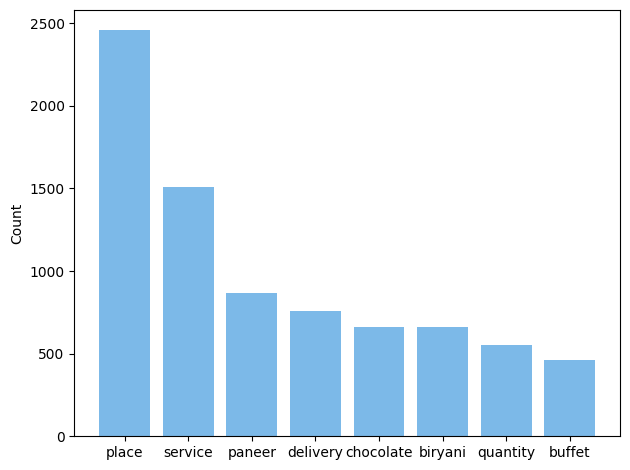

In [ ]:
# Sort by count and select top 8
top_8_topics = dominant_topic_counts.sort_values(by=['count'], ascending=False).head(8)

x_labels = top_8_topics['Topic_name'].str.split(" | ").str[0]

plt.bar(x_labels, top_8_topics['count'], color = "#7CB9E8")

plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
len(model_custom_merged.get_topic_info())

In [ ]:
model_custom_merged.get_topic_info()

In [ ]:
reviews_with_topics_custom.to_csv('reviews_with_topics_final_extended.csv', index=False)

In [ ]:
model_custom_merged.visualize_barchart(top_n_topics = 8, n_words=7, autoscale=True, title= "Top Topics Representations")

In [ ]:
model_custom_merged.visualize_term_rank()

In [ ]:
model_custom_merged.visualize_topics()

In [ ]:
log_perplexity = -1 * np.mean(np.log(np.sum(probs_custom, axis=1)))
perplexity = np.exp(log_perplexity)
print(perplexity)

1.7046741375171448
